In [1]:
%pylab inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy import asarray as ar
from scipy import math
import pylandau
import random

Populating the interactive namespace from numpy and matplotlib


# Importo il dataset

In [2]:
file = pd.read_csv(r'/home/gdeandrea/Scrivania/UNI/Econofisica/MyModels/Epstein/PRESE DATI/A-Valore Soglia/dati_rivolte_lunghe')
file.head()

,x,y,color,pen down?,x.1,y.1,color.1,pen down?.1,x.2,y.2,color.2,pen down?.2
0,0,1120,55,True,0,0,0,True,0,0,15,True
1,1,1098,55,True,1,17,0,True,1,5,15,True
2,2,1096,55,True,2,23,0,True,2,1,15,True
3,3,1097,55,True,3,23,0,True,3,0,15,True
4,4,1090,55,True,4,29,0,True,4,1,15,True


In [3]:
df = file['y.2']
y = df.to_numpy()
y = y[220:]
x = ar(range(len(y)))

# Definizioni Utili

## Fit Utils

In [4]:
def chiquadronorm(oss, fit, sigma, ddof, aiuto=False, norm=True):
    'funzione che calcola il chiquadrato di una distribuzione osservata rispetto a una\
    forma funzionale nota'
    
    #prende liste monodimensionali come argomenti
    scarti = []
    scartiquadri = []
    scartiquadridivisi = []
    
    for i in range(len(oss)):
        scarti.append(oss[i]-fit[i])
        scartiquadri.append(scarti[i]*scarti[i])
        scartiquadridivisi.append(scartiquadri[i]/(sigma[i]*sigma[i]))
        
        if (aiuto==True):
            print('scarti= ', scarti[i])
            print('scartiquadri= ', scartiquadri[i])
            print('scartiquadridivisi= ', scartiquadridivisi[i])
            
    chiquadro=sum(scartiquadridivisi)
    chiquadroreg=chiquadro/ddof
    
    if(norm==True):
        return (chiquadroreg)
    else:
        return (chiquadro)

def cost_chiquadronorm(oss, fit, sigma, ddof, aiuto=False, norm=True):
    'funzione che calcola il chiquadrato di una distribuzione osservata rispetto a una\
    forma funzionale nota'
    
    #prende liste monodimensionali come argomenti
    scarti = []
    scartiquadri = []
    scartiquadridivisi = []
    
    for i in range(len(oss)):
        scarti.append(oss[i]-fit)
        scartiquadri.append(scarti[i]*scarti[i])
        scartiquadridivisi.append(scartiquadri[i]/(sigma[i]*sigma[i]))
        
        if (aiuto==True):
            print('scarti= ', scarti[i])
            print('scartiquadri= ', scartiquadri[i])
            print('scartiquadridivisi= ', scartiquadridivisi[i])
            
    chiquadro=sum(scartiquadridivisi)
    chiquadroreg=chiquadro/ddof
    
    if(norm==True):
        return (chiquadroreg)
    else:
        return (chiquadro)

    
def media_pesata(x, sigma):
    numeratore = 0
    denominatore = 0
    for i in range(len(x)):
        numeratore += x[i]/(sigma[i]**2)
        denominatore += 1/(sigma[i]**2)
    return numeratore/denominatore

def costante(x,q):
    return q

def retta(x,m,q):
    return m*x +q

def gauss(x,a,x0,sigma,baseline):
    'Ritorna array gaussiano a partire da lista x secondo i parametri a,x0,sigma'
    return (baseline + a*exp(-(x-x0)**2/(2*sigma*sigma)))


def lore(x, a, x0, y0, baseline):
    'Ritorna array lorentziano a partire da lista x secondo i parametri a,x0,yo'
    return (baseline + a*(y0/(((x - x0)**2) + (y0**2))))

def fattoriale(x):
    temp_list = []

    for ics in x:
        f=1
        for i in range(1,ics+1):
            f*=i
        temp_list.append(f)
    return(temp_list)

def poisson(x, a, media, baseline):
    result = baseline + a*(media**x)*np.exp(-media)/fattoriale(x)
    return(result)

def landau(x, mpv, eta, A, baseline):
    x=double(x)
    'Ritorna array landauiano a partire da lista x secondo i parametri suoi'
    return (baseline + double(pylandau.landau(x, mpv=mpv, eta=eta, A=A)))

## Findings of previous step

In [5]:
soglia = 128.1241472701187
err_soglia = 12.6007119219633

## Selecting Spikes

In [6]:
def isola_spikes (y, datiesterni):
    '''
    Dati i dati sugli attivi, ritorna due dizionari: 
    {num_rivolta: [valori attivi]}
    {num_rivolta: [tick corrispondenti]}
    '''
    rivolte_diz = {}
    tick_rivolte_diz = {}
    temp_rivolta_list = []
    temp_tick_list = []
    rivolte_counter = 0
    cerarivolta = False
    
    for i in range(len(y)):
        
        ##aggiustato a 12 per non avere rivoltini
        if y[i] > 12:
            temp_rivolta_list.append(y[i])
            temp_tick_list.append(i)
            if cerarivolta == False:
                rivolte_counter += 1
                cerarivolta = True
        else:
            if cerarivolta == True:
                lunghezza=len(temp_rivolta_list)
                if rivolte_counter > 1:
                    if datiesterni == 1:
                        temp_rivolta_list.insert(0, y[i-lunghezza-1])
                        temp_tick_list.insert(0, i-lunghezza-1)
                    if datiesterni == 2:
                        temp_rivolta_list.insert(0, y[i-lunghezza-1])
                        temp_rivolta_list.insert(0, y[i-lunghezza-2])
                        temp_tick_list.insert(0, i-lunghezza-1)
                        temp_tick_list.insert(0, i-lunghezza-2)
                    if datiesterni == 3:
                        temp_rivolta_list.insert(0, y[i-lunghezza-1])
                        temp_rivolta_list.insert(0, y[i-lunghezza-2])
                        temp_rivolta_list.insert(0, y[i-lunghezza-3])
                        temp_tick_list.insert(0, i-lunghezza-1)
                        temp_tick_list.insert(0, i-lunghezza-2)
                        temp_tick_list.insert(0, i-lunghezza-3)
                else:
                    if datiesterni == 1:
                        temp_rivolta_list.insert(0, 0)
                        temp_tick_list.insert(0, i-lunghezza-1)
                    if datiesterni == 2:
                        temp_rivolta_list.insert(0, 0)
                        temp_rivolta_list.insert(0, 0)
                        temp_tick_list.insert(0, i-lunghezza-1)
                        temp_tick_list.insert(0, i-lunghezza-2)
                    if datiesterni == 3:
                        temp_rivolta_list.insert(0, 0)
                        temp_rivolta_list.insert(0, 0)
                        temp_rivolta_list.insert(0, 0)
                        temp_tick_list.insert(0, i-lunghezza-1)
                        temp_tick_list.insert(0, i-lunghezza-2)
                        temp_tick_list.insert(0, i-lunghezza-3)
                    
                if datiesterni == 1:
                        temp_rivolta_list.append(y[i])
                        temp_tick_list.append(i)
                if datiesterni == 2:
                        temp_rivolta_list.append(y[i])
                        temp_rivolta_list.append(y[i+1])
                        temp_tick_list.append(i)
                        temp_tick_list.append(i+1)
                if datiesterni == 3:
                        temp_rivolta_list.append(y[i])
                        temp_rivolta_list.append(y[i+1])
                        temp_rivolta_list.append(y[i+2])
                        temp_tick_list.append(i)
                        temp_tick_list.append(i+1)
                        temp_tick_list.append(i+2)
                
                rivolte_diz[str(rivolte_counter)+'_spike'] = temp_rivolta_list
                tick_rivolte_diz[str(rivolte_counter)+'_spike'] = temp_tick_list
                temp_rivolta_list = []
                temp_tick_list = []
                cerarivolta = False
                
    return rivolte_diz, tick_rivolte_diz

# Analisi

## Creo dizionario degli spikes

In [7]:
spikes_dict, spikes_tick_dict = isola_spikes(y, 3)

## Seleziono rivolte in base a valore di soglia trovato precedentemente

In [8]:
print('SOGLIA:', np.round(soglia, 0),', errore:', np.round(err_soglia, 0))

SOGLIA: 128.0 , errore: 13.0


In [9]:
## If soglia-errore_soglia < y + errore_y --> rivolta
rivolte_dict = {}
tick_rivolte_dict = {}
rivolte_counter = 0
for spike in spikes_dict:
    y = spikes_dict[spike]
    x = spikes_tick_dict[spike]
    if np.max(y)+np.sqrt(np.max(y)) > soglia-err_soglia:
        rivolte_counter += 1
        rivolte_dict[str(rivolte_counter)+'_rivolta']=y
        tick_rivolte_dict[str(rivolte_counter)+'_rivolta']=x

In [10]:
len(spikes_dict)

263

In [11]:
len(rivolte_dict)

206

## Calcolo Metriche: Durata, tempi d'attesa e ampiezza  
Tutte le metriche vengono ricavate dal calcolo dei parametri derivanti dalla procedura di fit:  
- Durata = 6sigma della rivolta considerata  
- Tempo attesa = (media[rivolta_i+1] - 3sigma[rivolta_i+1]) - (media[rivolta_i] + 3sigma[rivolta_i])  
- Ampiezza = parametro del fit  
  
Gli errori vengono calcolati dalla propagazione degli errori sui parametri del fit

In [12]:
## For loop che mi serve a trovare ampiezza, media e deviazione standard di ognuna delle rivolte
gauss_params_dict = {}
gauss_err_params_dict = {}
for rivolte in rivolte_dict:
    ## non considero 80_rivolta, è un errore della funzione 'isola_spike' che la isola come rivolta
    if rivolte != '80_rivolta':
        print(rivolte)
        temp_list = []
        temp_err_list = []
        y = rivolte_dict[rivolte]
        x = tick_rivolte_dict[rivolte]
        print(x)
        print(y)
        err_y = np.where(np.sqrt(y)==0,1,np.sqrt(y))
        gauss_params,gauss_cov = curve_fit(gauss,x,y,p0=[200,((x[-1]-x[0])/2)+x[0],4.,0.],sigma=err_y)
        temp_list.append(gauss_params[0])
        temp_list.append(gauss_params[1])
        temp_list.append(gauss_params[2])
        temp_err_list.append(np.sqrt(np.abs(gauss_cov[0][0])))
        temp_err_list.append(np.sqrt(np.abs(gauss_cov[1][1])))
        temp_err_list.append(np.sqrt(np.abs(gauss_cov[2][2])))
        gauss_params_dict[rivolte] = temp_list
        gauss_err_params_dict[rivolte] = temp_err_list

1_rivolta
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 0, 0, 28, 146, 325, 302, 254, 203, 159, 100, 44, 1, 0, 0]
2_rivolta
[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 0, 1, 14, 23, 59, 161, 193, 170, 116, 58, 17, 0, 1, 1]
3_rivolta
[59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
[0, 0, 11, 68, 133, 179, 182, 137, 87, 30, 0, 0, 2]
4_rivolta
[87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
[1, 0, 1, 21, 45, 76, 170, 249, 211, 159, 105, 59, 10, 0, 1]
5_rivolta
[120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133]
[3, 2, 5, 91, 261, 303, 250, 204, 153, 99, 33, 3, 0, 0]
6_rivolta
[145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158]
[0, 0, 4, 42, 83, 184, 200, 152, 110, 57, 24, 1, 0, 0]
7_rivolta
[176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190]
[1, 1, 8, 45, 167, 299, 249, 211, 171, 132, 80, 23, 1, 0, 0]
8_rivolta
[225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236,

58_rivolta
[1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710]
[1, 0, 10, 38, 113, 148, 161, 134, 76, 18, 11, 5, 2]
59_rivolta
[1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733]
[1, 1, 9, 105, 235, 243, 195, 154, 104, 45, 2, 0, 0]
60_rivolta
[1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758]
[0, 1, 3, 37, 104, 233, 203, 163, 119, 68, 18, 1, 0, 1]
61_rivolta
[1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782]
[0, 0, 0, 57, 155, 240, 211, 173, 125, 93, 42, 2, 0, 0]
62_rivolta
[1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806]
[1, 1, 12, 33, 100, 133, 205, 175, 130, 77, 28, 1, 6, 0]
63_rivolta
[1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833]
[1, 0, 3, 15, 58, 188, 258, 216, 177, 140, 96, 37, 0, 0, 0]
64_rivolta
[1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877]

139_rivolta
[4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4233, 4234, 4235, 4236]
[0, 0, 1, 26, 132, 281, 289, 244, 202, 150, 89, 30, 4, 0, 0]
140_rivolta
[4250, 4251, 4252, 4253, 4254, 4255, 4256, 4257, 4258, 4259, 4260, 4261, 4262, 4263, 4264]
[0, 0, 0, 32, 98, 217, 248, 205, 150, 107, 53, 13, 4, 0, 0]
141_rivolta
[4279, 4280, 4281, 4282, 4283, 4284, 4285, 4286, 4287, 4288, 4289, 4290, 4291, 4292, 4293]
[0, 0, 1, 21, 114, 263, 296, 249, 205, 157, 101, 48, 1, 1, 1]
142_rivolta
[4304, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4316, 4317]
[0, 0, 6, 19, 60, 130, 208, 168, 128, 100, 46, 6, 0, 0]
143_rivolta
[4327, 4328, 4329, 4330, 4331, 4332, 4333, 4334, 4335, 4336, 4337, 4338, 4339, 4340, 4341]
[3, 1, 5, 21, 43, 55, 98, 150, 141, 124, 80, 33, 4, 0, 0]
144_rivolta
[4367, 4368, 4369, 4370, 4371, 4372, 4373, 4374, 4375, 4376, 4377, 4378]
[0, 0, 0, 36, 110, 147, 156, 107, 52, 3, 0, 1]
145_rivolta
[4397, 4398, 4399, 4400, 4401, 4402, 4403, 4404, 4

In [13]:
del rivolte_dict['80_rivolta']
del tick_rivolte_dict['80_rivolta']

### Durata

In [17]:
## calcolo la durata delle singole rivolte come 6 per la sigma della rivolta (hp:gaussiane)
###e errori su singole durate propagando gli errori sulla sigma (6*err_assoluto sigma)
durate_list = [gauss_params_dict[rivolte][2]*6 for rivolte in rivolte_dict]
err_durate_list = [gauss_err_params_dict[rivolte][2]*6 for rivolte in rivolte_dict]
durate_list = np.abs(durate_list)
err_durate_list = np.abs(err_durate_list)

## calcolo media pesata e errore su media
media_pesata_durate = media_pesata(durate_list, err_durate_list)
err_media_pesata_durate = np.sqrt(np.sum((durate_list - media_pesata_durate)**2)/(len(durate_list)*(len(durate_list)-1)))

In [18]:
np.argmax(err_durate_list)

163

In [19]:
durate_list[163]

0.5402241640222005

In [20]:
err_durate_list[163]

152046157981.62918

<ErrorbarContainer object of 3 artists>

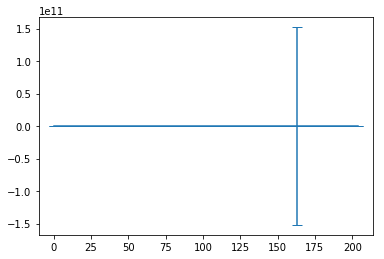

In [21]:
plt.errorbar(range(len(durate_list)), durate_list, yerr=err_durate_list,solid_capstyle='projecting',capsize=5)

### Tempi attesa

In [22]:
## calcolo liste dei tick di inizio e fine rivolte con relativi errori 
###trovati con propagazione degli errori dagli errori dei parametri del fit
###(start = media-3sigma --> err_start = err_media + 3err_sigma)
start_tick_list = []
end_tick_list = []
err_start_tick_list = []
err_end_tick_list = []

for rivolte in gauss_params_dict:
    media = gauss_params_dict[rivolte][1]
    sigma = np.abs(gauss_params_dict[rivolte][2])
    err_media = gauss_err_params_dict[rivolte][1]
    err_sigma = gauss_err_params_dict[rivolte][2]
    start_tick_list.append(media - 3*sigma)
    end_tick_list.append(media + 3*sigma)
    err_start_tick_list.append(err_media + 3*err_sigma)
    err_end_tick_list.append(err_media + 3*err_sigma)

In [23]:
## Calcolo tempi di attesa dalle liste dei tick di inizio e fine rivolte e relativi errori
###calcolati con la propagazione dagli errori dei tick di inizio e fine rivolte
###(tempo_attesa = start[i+1]-end[i] --> err_tempo_attesa = err_start[i+1] + err_end[i])
tempi_attesa_list = []
err_tempi_attesa_list = []
for i in range(len(end_tick_list)-1):
    tempi_attesa_list.append(start_tick_list[i+1] - end_tick_list[i])
    err_tempi_attesa_list.append(err_start_tick_list[i+1] + err_end_tick_list[i])

In [25]:
## calcolo media pesata e errore su media
media_pesata_tempi_attesa = media_pesata(tempi_attesa_list, err_tempi_attesa_list)
err_media_pesata_tempi_attesa = np.sqrt(np.sum((tempi_attesa_list - media_pesata_tempi_attesa)**2)/(len(tempi_attesa_list)*(len(tempi_attesa_list)-1)))

<ErrorbarContainer object of 3 artists>

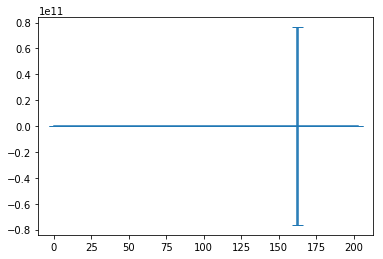

In [26]:
plt.errorbar(range(len(tempi_attesa_list)), tempi_attesa_list, yerr=err_tempi_attesa_list,solid_capstyle='projecting',capsize=5)

In [27]:
np.argmax(err_tempi_attesa_list)

162

### Ampiezza

In [28]:
## Calcolo ampiezze per ogni rivolta e errore da propagazione errori del fit
ampiezze_list = [gauss_params_dict[rivolte][0] for rivolte in rivolte_dict]
err_ampiezze_list = [gauss_err_params_dict[rivolte][0] for rivolte in rivolte_dict]
ampiezze_list = np.abs(ampiezze_list)
err_ampiezze_list = np.abs(err_ampiezze_list)

## Calcolo media pesata e errore su media
media_pesata_ampiezze = media_pesata(ampiezze_list, err_ampiezze_list)
err_media_pesata_ampiezze = np.sqrt(np.sum((ampiezze_list - media_pesata_ampiezze)**2)/(len(ampiezze_list)*(len(ampiezze_list)-1)))

<ErrorbarContainer object of 3 artists>

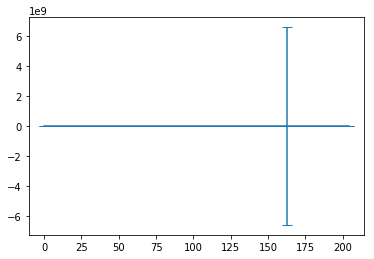

In [29]:
plt.errorbar(range(len(ampiezze_list)), ampiezze_list, yerr=err_ampiezze_list,solid_capstyle='projecting',capsize=5)

In [30]:
np.argmax(err_ampiezze_list)

163

**Tutte e tre le metriche relative alla stessa rivolta presentano un errore enorme. Lo tolgo perchè dev'essere dovuto al calcolo dei parametri della procedura di fit o alla funzione che seleziona le rivolte.**

In [49]:
a = np.copy(durate_list)
err_a = np.copy(err_durate_list)
b = np.copy(tempi_attesa_list)
err_b = np.copy(err_tempi_attesa_list)
c = np.copy(ampiezze_list)
err_c = np.copy(err_ampiezze_list)

In [50]:
a = np.delete(a,163)
err_a = np.delete(err_a,163)
b = np.delete(b,162)
err_b = np.delete(err_b,162)
b = np.delete(b,162)
err_b = np.delete(err_b,162)
c = np.delete(c,163)
err_c = np.delete(err_c,163)

### Plots

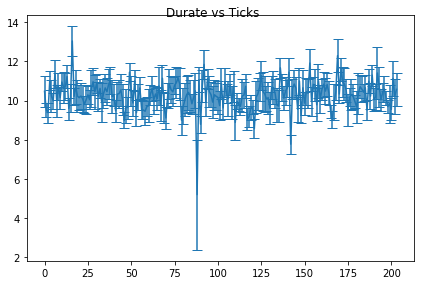

In [35]:
plt.errorbar(range(len(a)), a, yerr=err_a,solid_capstyle='projecting',capsize=5)
plt.suptitle('Durate vs Ticks')
plt.tight_layout()
plt.show()

In [54]:
np.argmax(err_a)

88

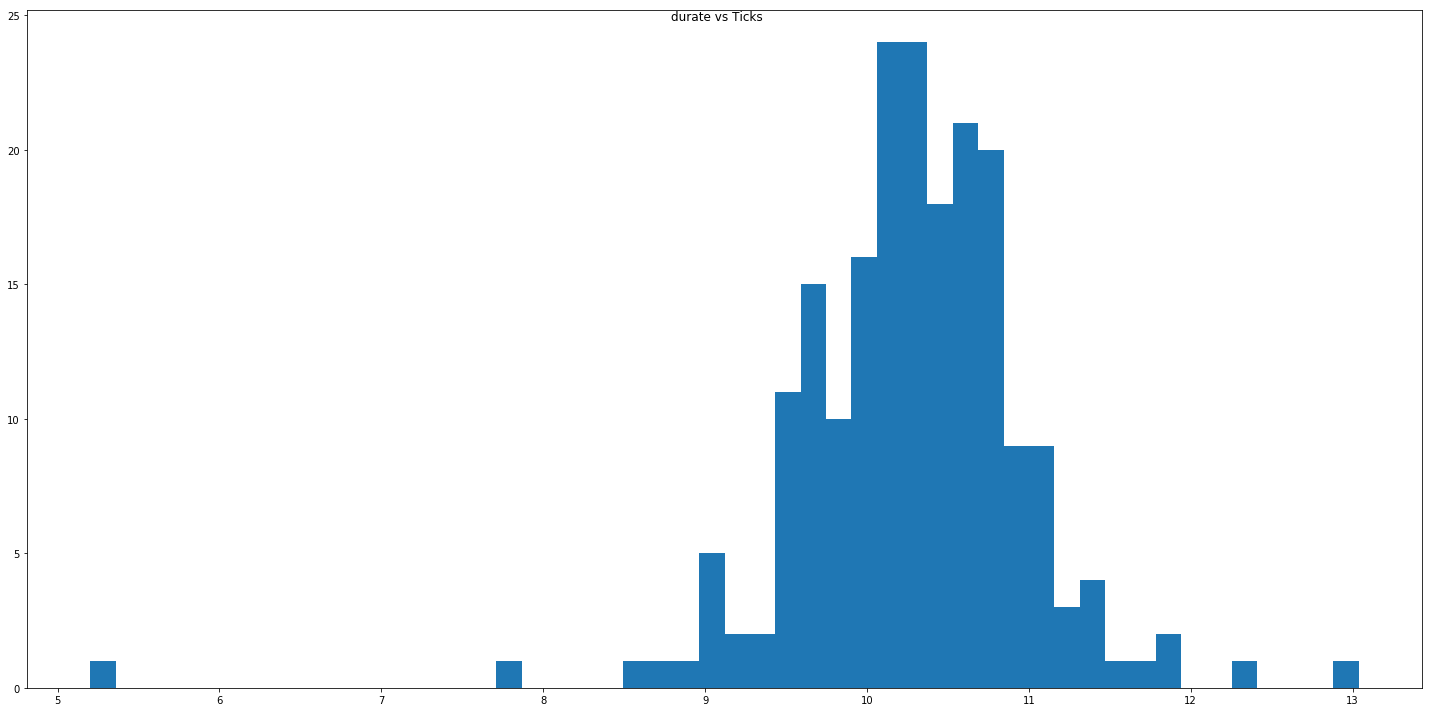

In [47]:
plt.figure(figsize=(20,10))
plt.hist(a, bins=50)
plt.suptitle('durate vs Ticks')
plt.tight_layout()
plt.show()

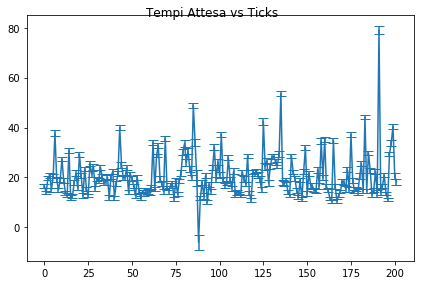

In [45]:
plt.errorbar(range(len(b)), b, yerr=err_b,solid_capstyle='projecting',capsize=5)
plt.suptitle('Tempi Attesa vs Ticks')
plt.tight_layout()
plt.show()

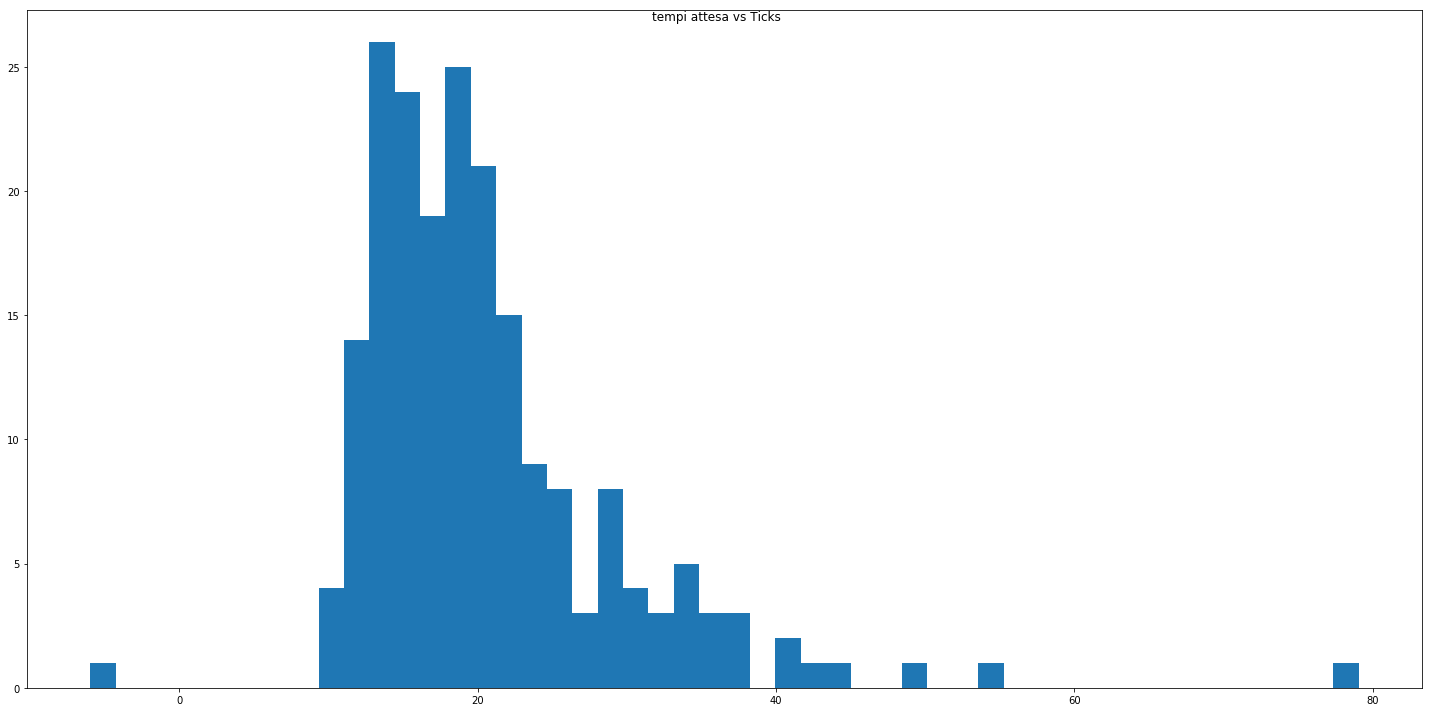

In [48]:
plt.figure(figsize=(20,10))
plt.hist(b, bins=50)
plt.suptitle('tempi attesa vs Ticks')
plt.tight_layout()
plt.show()

In [56]:
np.argmin(b)

88

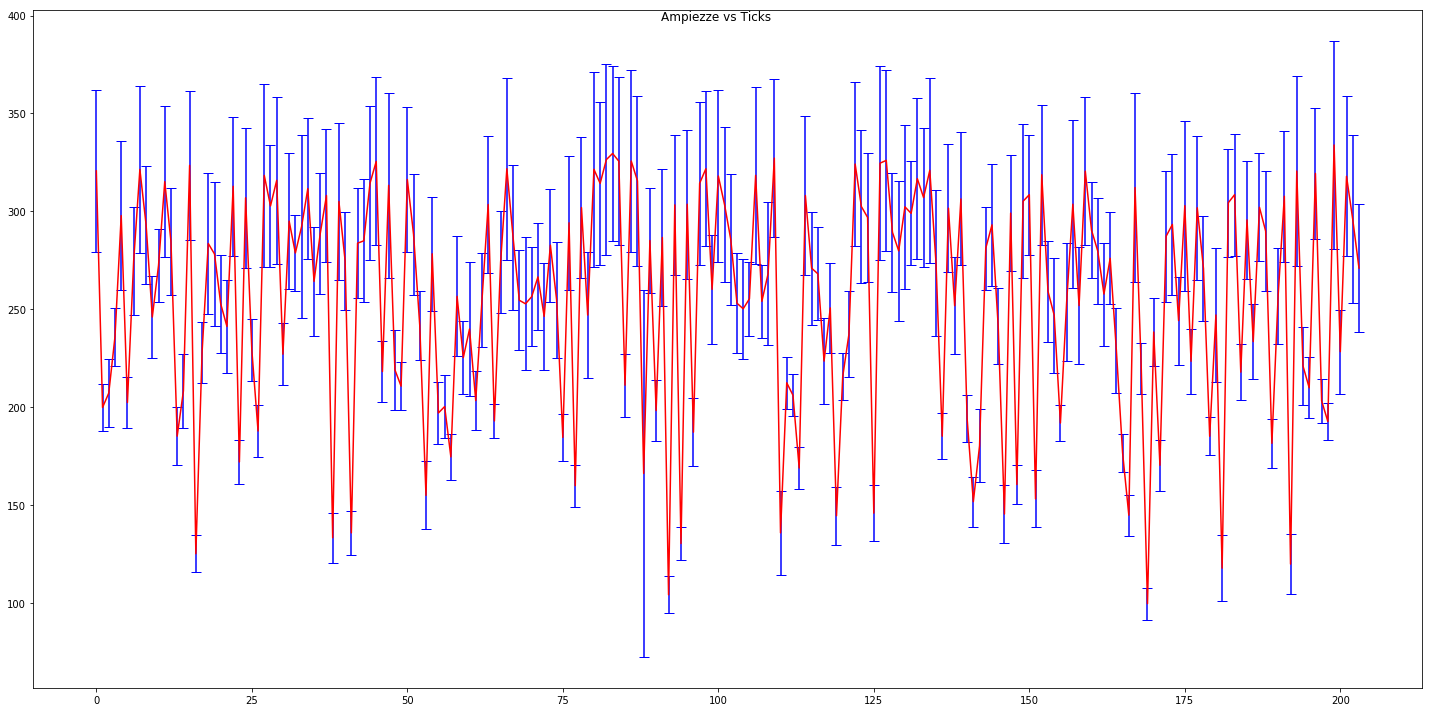

In [37]:
plt.figure(figsize=(20,10))
plt.errorbar(range(len(c)), c, fmt='r-',yerr=err_c,solid_capstyle='projecting',capsize=5,ecolor='blue')
plt.suptitle('Ampiezze vs Ticks')
plt.tight_layout()
plt.show()

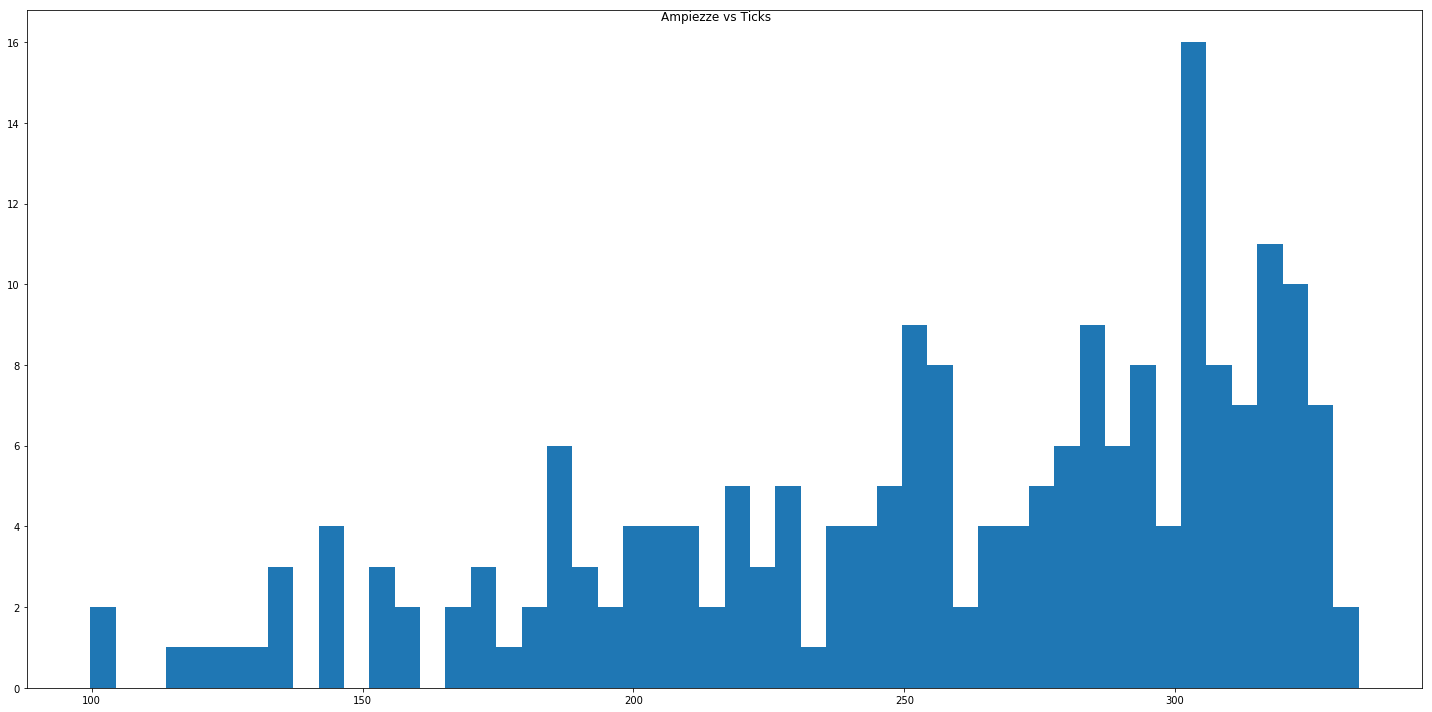

In [38]:
plt.figure(figsize=(20,10))
plt.hist(c, bins=50)
plt.suptitle('Ampiezze vs Ticks')
plt.tight_layout()
plt.show()

**89esima rivolta è outlier sia per quanto riguarda la durata che il tempo di attesa(negativo), elimino il punto in questione dalle mie metriche**

In [60]:
print(a[np.argmin(a)]), 
print(np.argmin(a))
print(b[np.argmin(b)]), 
print(np.argmin(b))

5.202837460062643
88
-5.969797307206136
88


(None, None)

In [61]:
a = np.delete(a,88)
err_a = np.delete(err_a,88)
b = np.delete(b,88)
err_b = np.delete(err_b,88)
c = np.delete(c,88)
err_c = np.delete(err_c,88)

### Re-plots

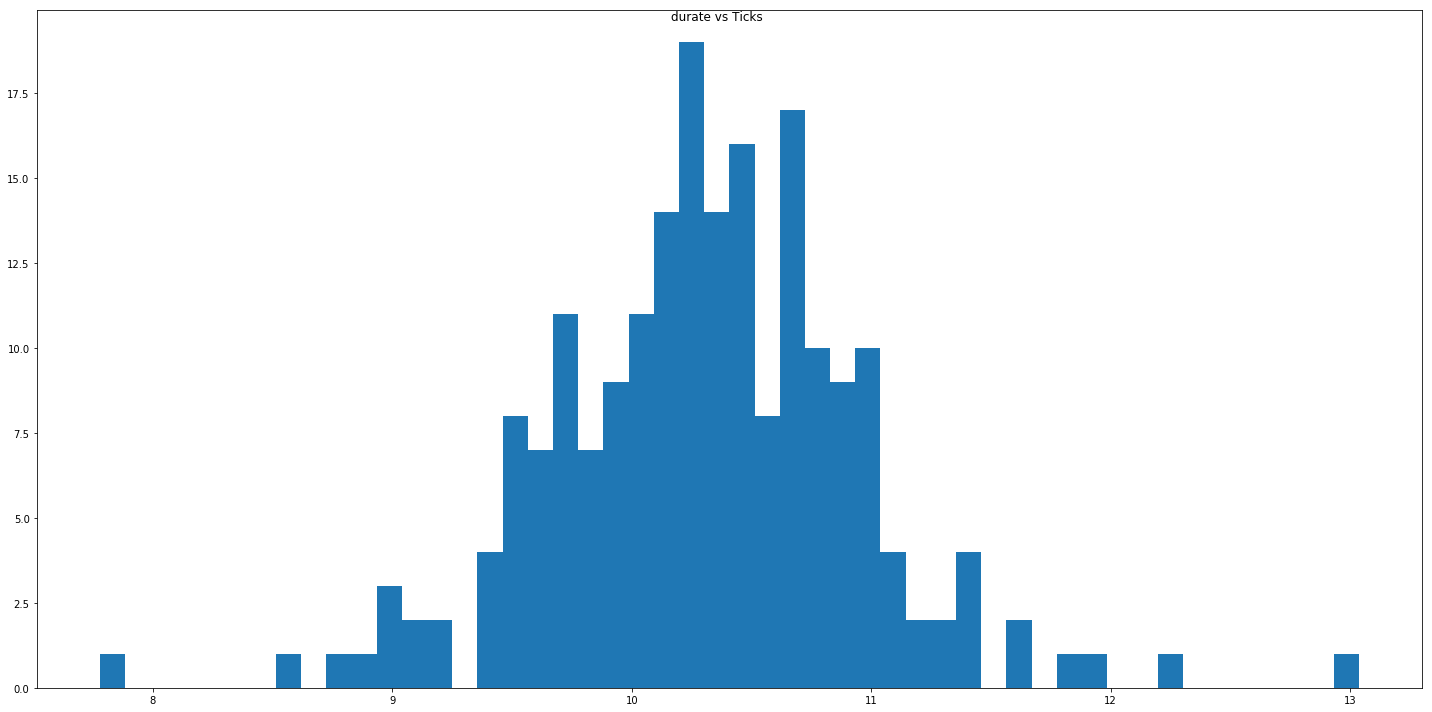

In [62]:
plt.figure(figsize=(20,10))
plt.hist(a, bins=50)
plt.suptitle('durate vs Ticks')
plt.tight_layout()
plt.show()

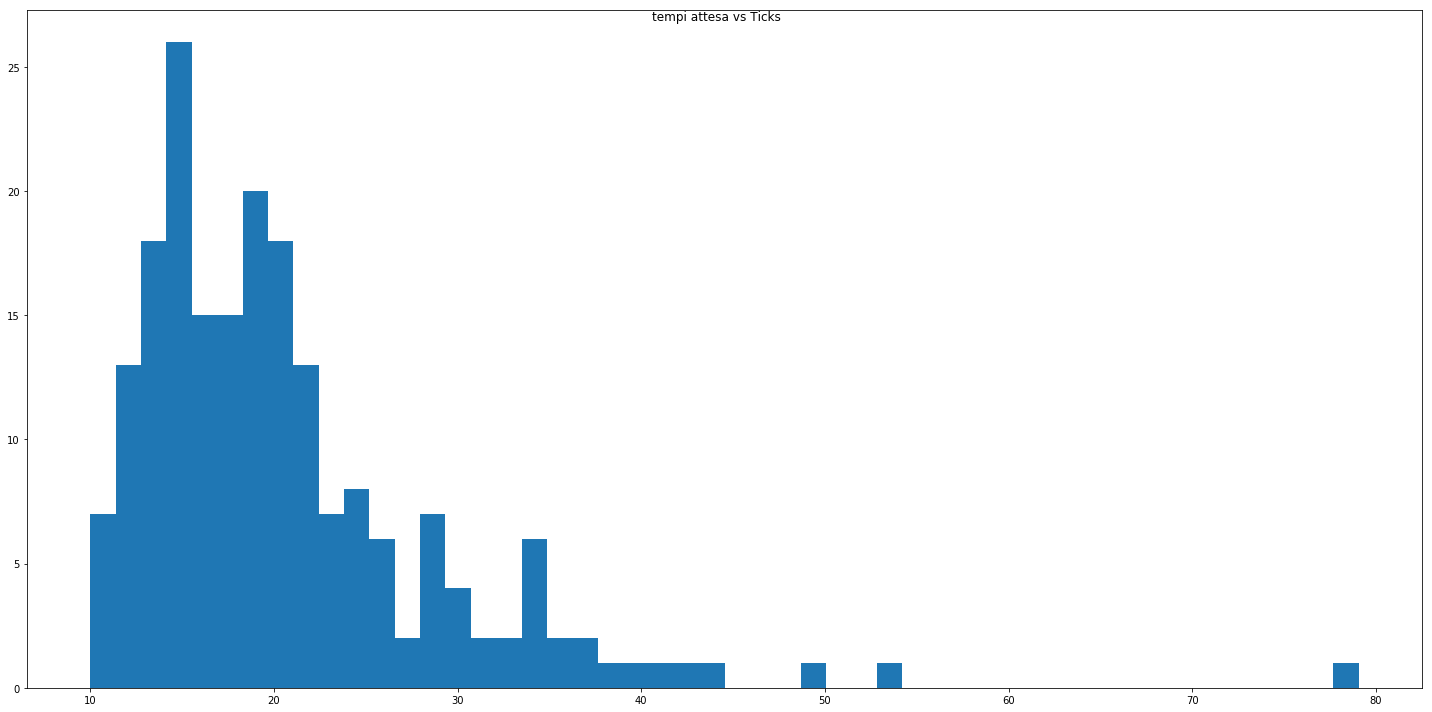

In [63]:
plt.figure(figsize=(20,10))
plt.hist(b, bins=50)
plt.suptitle('tempi attesa vs Ticks')
plt.tight_layout()
plt.show()

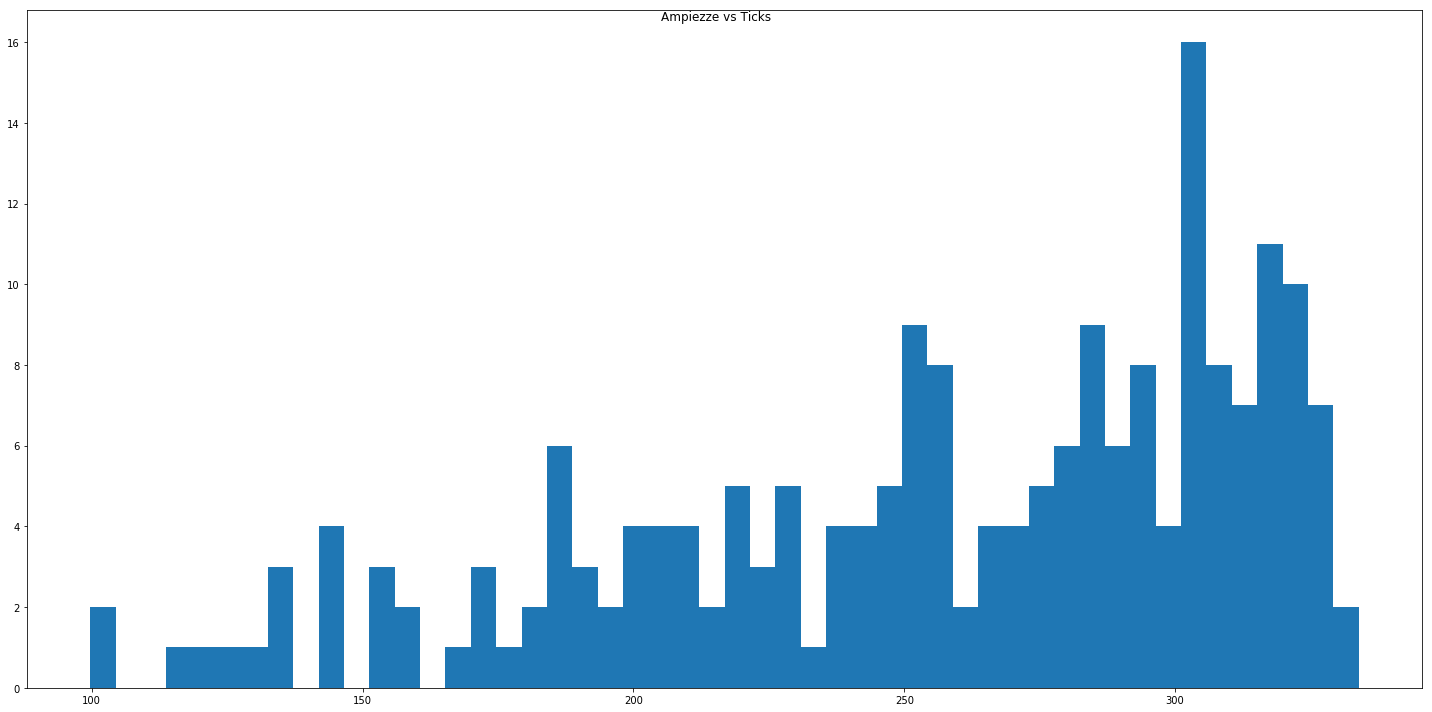

In [64]:
plt.figure(figsize=(20,10))
plt.hist(c, bins=50)
plt.suptitle('Ampiezze vs Ticks')
plt.tight_layout()
plt.show()